Index(['any_alcohol_past_month - Yes', 'any_alcohol_past_month - No',
       'any_alcohol_past_month - Don’t know/Not sure',
       'any_alcohol_past_month - Refused', 'any_physical_activity - Yes',
       'any_physical_activity - No',
       'any_physical_activity - Don’t know/Not sure',
       'current_smoking_frequency - Every day',
       'current_smoking_frequency - Some days',
       'current_smoking_frequency - Not at all',
       ...
       'employment_max', 'unemployment_mean', 'unemployment_min',
       'unemployment_max', 'labor_force_mean', 'labor_force_min',
       'labor_force_max', 'unemployment_rate_mean', 'unemployment_rate_min',
       'unemployment_rate_max'],
      dtype='object', length=235)


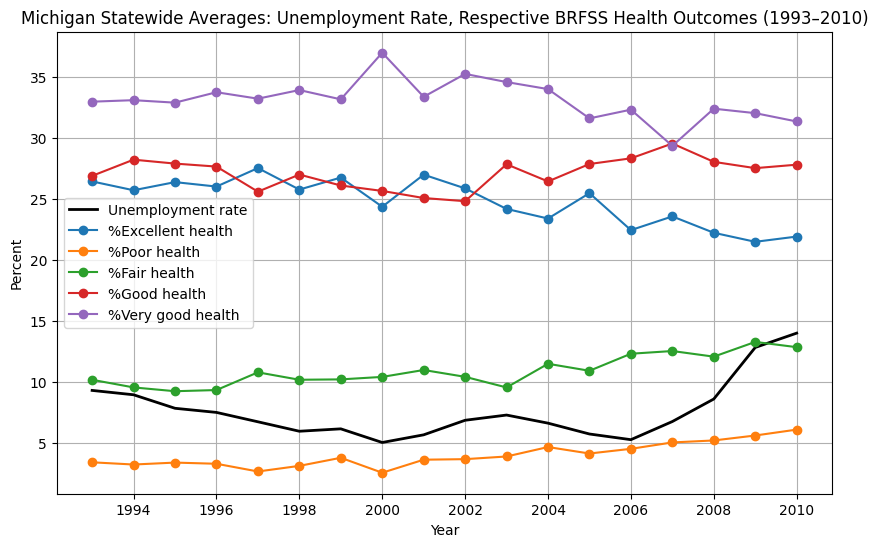

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Load merged dataset from 01_merge_LA_BRFSS
df = pd.read_csv("california_health_bls_merged.csv")

# Drop non-numeric columns
X = df.drop(columns=["county_name", "survey_year"])

print(X.columns)

# BRFSS includes a core question on self-reported overall health and wellbeing. Proxy for overall health/wellbeing.
trend_vars = {
    "general_health_status - Excellent": "%Excellent health",
    "general_health_status - Poor": "%Poor health",
    "general_health_status - Fair" : "%Fair health",
    "general_health_status - Good" : "%Good health",
    "general_health_status - Very good" : "%Very good health"
}

# Compute statewide averages by year for each above
trend = df.groupby("survey_year")[["unemployment_rate_mean"] + list(trend_vars.keys())].mean()

plt.figure(figsize=(10,6))

# Plot unemployment
plt.plot(trend.index, trend["unemployment_rate_mean"], label="Unemployment rate", color="black", linewidth=2)

# Plot health variables
for col, label in trend_vars.items():
    plt.plot(trend.index, trend[col], marker="o", label=label)

plt.title("California Statewide Averages: Unemployment Rate, Respective BRFSS Health Outcomes (1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)


plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [2]:
import statsmodels.api as sm

y = df["general_health_status - Excellent"]  # health outcome
X = df[["employment_mean", "unemployment_rate_mean"]]  # predictors
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     general_health_status - Excellent   R-squared:                       0.181
Model:                                           OLS   Adj. R-squared:                  0.178
Method:                                Least Squares   F-statistic:                     52.21
Date:                               Fri, 03 Oct 2025   Prob (F-statistic):           3.32e-21
Time:                                       02:20:11   Log-Likelihood:                -1506.8
No. Observations:                                474   AIC:                             3020.
Df Residuals:                                    471   BIC:                             3032.
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
                             coef    std err          t     

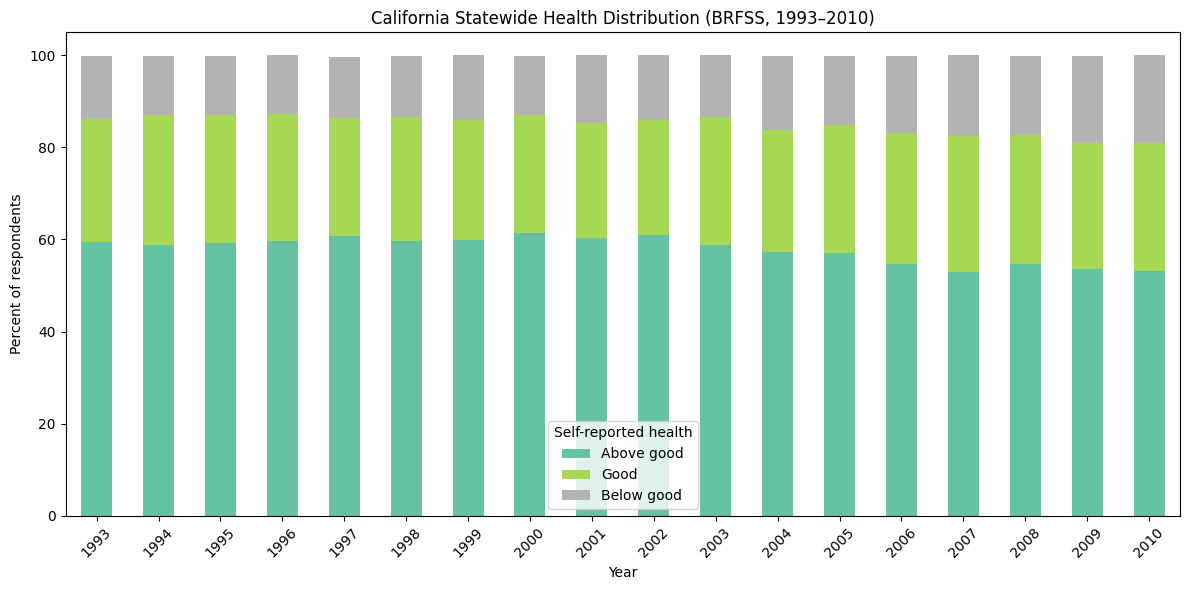

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load merged dataset
df = pd.read_csv("california_health_bls_merged.csv")


df.columns

# Define health categories
health_vars = {
    "general_health_status - Excellent": "Excellent",
    "general_health_status - Very good": "Very good",
    "general_health_status - Good": "Good",
    "general_health_status - Fair": "Fair",
    "general_health_status - Poor": "Poor"
}

# Compute statewide averages
trend = df.groupby("survey_year")[list(health_vars.keys())].mean()

# Collapse into 3 categories
trend["Above good"] = trend["general_health_status - Excellent"] + trend["general_health_status - Very good"]
trend["Good"]       = trend["general_health_status - Good"]
trend["Below good"] = trend["general_health_status - Fair"] + trend["general_health_status - Poor"]

# Keep only the collapsed categories
collapsed = trend[["Above good", "Good", "Below good"]]

# Plot as stacked bars over time
collapsed.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="Set2"
)

plt.title("California Statewide Health Distribution (BRFSS, 1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent of respondents")
plt.legend(title="Self-reported health")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Found 91 fruit columns


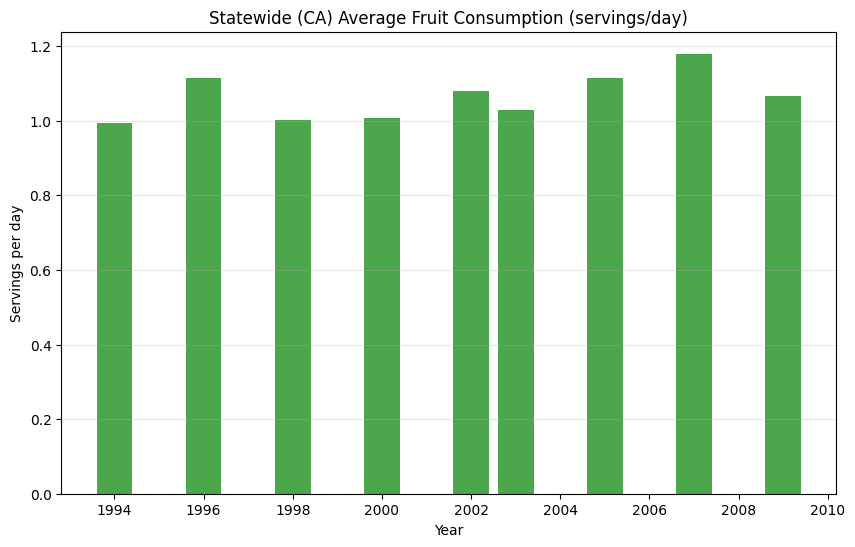

In [24]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

PREFIX = "eats_fruit"   # change to the exact question prefix you see

# 1) find all columns for this question
fruit_cols = [c for c in df.columns if c.lower().startswith(PREFIX.lower() + " - ")]
if not fruit_cols:
    print("No 'eats_fruit - ...' columns found.")
else:
    print(f"Found {len(fruit_cols)} fruit columns")

# 2) parse a column label like "eats_fruit - 8 times/week" -> daily rate (8/7)
def label_to_daily_rate(colname: str) -> float | None:
    # keep only the part after " - "
    label = colname.split(" - ", 1)[1].strip().lower()

    # ignore nonresponse/special codes
    if ("don’t know" in label) or ("don't know" in label) or ("not sure" in label) or ("refused" in label):
        return None
    if label.startswith("code "):     # unknown legacy codes; safest to ignore
        return None

    # match patterns like "9 times/day", "1 time/day", "12 times/week", "5 times/month", etc.
    m = re.match(r"^\s*(\d+)\s*times?/(\w+)\s*$", label)
    if not m:
        # sometimes labels may be "X per week" or "X/day"
        m = re.match(r"^\s*(\d+)\s*(?:per|/)\s*(\w+)\s*$", label)
    if not m:
        return None

    n = float(m.group(1))
    unit = m.group(2)

    if unit.startswith("day"):
        return n
    if unit.startswith("week"):
        return n / 7.0
    if unit.startswith("month"):
        return n / 30.0
    if unit.startswith("year"):
        return n / 365.0
    return None  # unknown unit

# 3) build a per-column rate vector
rates = {c: label_to_daily_rate(c) for c in fruit_cols}
rate_series = pd.Series(rates, dtype="float64")
usable_cols = [c for c, r in rates.items() if r is not None]

if not usable_cols:
    raise ValueError("No usable fruit columns with parseable frequency labels were found.")

# 4) compute statewide yearly averages (shares) for those columns
shares = df.groupby("survey_year")[usable_cols].mean()

# If your shares are in percent (0–100), convert to proportions (0–1)
if shares.max(numeric_only=True).max() > 1.0:
    shares = shares / 100.0

# 5) expected servings/day = sum over categories (share * daily_rate)
expected_per_day = (shares * rate_series[usable_cols]).sum(axis=1)
expected_per_day = expected_per_day.replace(0, np.nan)

# 6) plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(expected_per_day.index, expected_per_day.values, color="green", alpha=0.7)

ax.set_title("Statewide (CA) Average Fruit Consumption (servings/day)")
ax.set_xlabel("Year")
ax.set_ylabel("Servings per day")
ax.grid(axis="y", alpha=0.3)

# lock x-axis ticks to integer years
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()



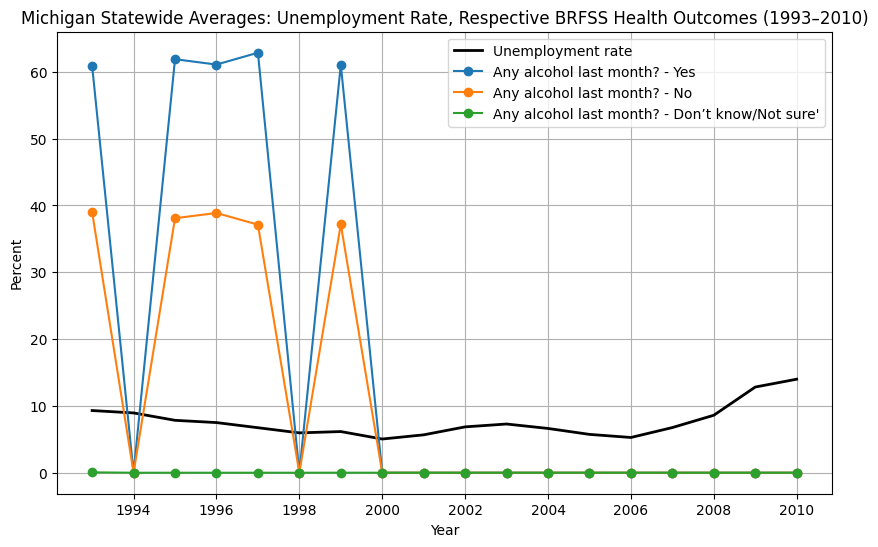

In [18]:
# Let's test some non-general_health_status variables in our merged dataset.
trend_vars = {
    "any_alcohol_past_month - Yes" : "Any alcohol last month? - Yes", 
    "any_alcohol_past_month - No" : "Any alcohol last month? - No",
    'any_alcohol_past_month - Don’t know/Not sure' : "Any alcohol last month? - Don’t know/Not sure'", 
}

# Compute statewide averages by year for each above
trend = df.groupby("survey_year")[["unemployment_rate_mean"] + list(trend_vars.keys())].mean()

plt.figure(figsize=(10,6))

# Plot unemployment
plt.plot(trend.index, trend["unemployment_rate_mean"], label="Unemployment rate", color="black", linewidth=2)

# Plot health variables
for col, label in trend_vars.items():
    plt.plot(trend.index, trend[col], marker="o", label=label)

plt.title("Michigan Statewide Averages: Unemployment Rate, Respective BRFSS Health Outcomes (1993–2010)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)


plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# Uh oh, major data quality issues; we don't have observations for most of our specified range of interest! 

current_smoking_frequency - Every day

current_smoking_frequency - Every day:
survey_year
1993    13
1994    17
1995    15
1996    18
1997    17
1998    16
1999    18
2000    17
2001    16
2002    19
2003    19
2004    21
2005    27
2006    26
2007    53
2008    54
2009    54
2010    54
Name: current_smoking_frequency - Every day, dtype: int64
current_smoking_frequency - Some days

current_smoking_frequency - Some days:
survey_year
1993    13
1994    17
1995    15
1996    18
1997    17
1998    16
1999    18
2000    17
2001    16
2002    19
2003    19
2004    21
2005    27
2006    26
2007    53
2008    54
2009    54
2010    54
Name: current_smoking_frequency - Some days, dtype: int64
current_smoking_frequency - Not at all

current_smoking_frequency - Not at all:
survey_year
1993    13
1994    17
1995    15
1996    18
1997    17
1998    16
1999    18
2000    17
2001    16
2002    19
2003    19
2004    21
2005    27
2006    26
2007    53
2008    54
2009    54
2010    54
Name: current_smok

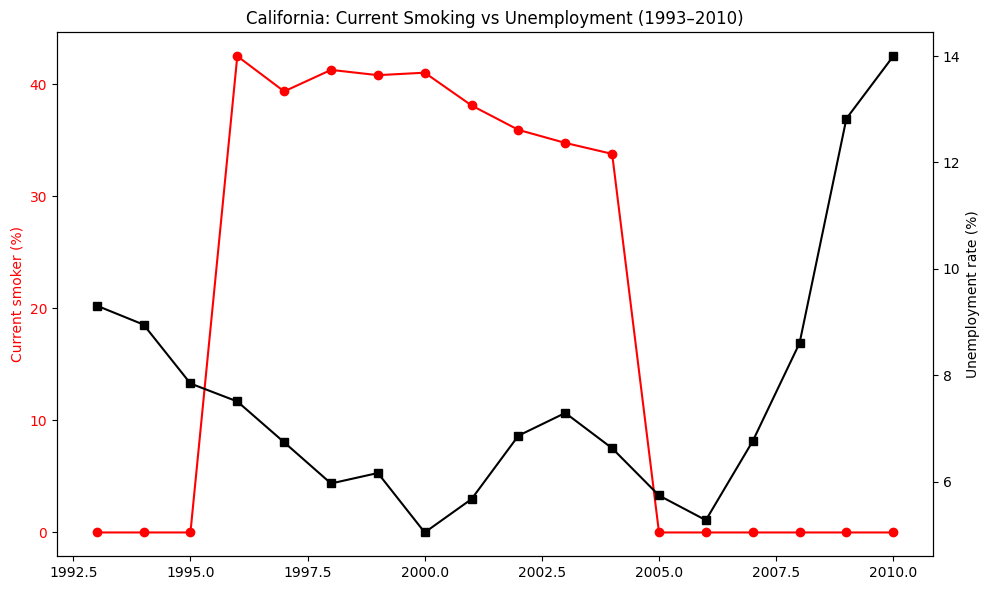

In [33]:
smk_cols = [c for c in df.columns if any(k in c.lower() for k in ["smok"])]

for col in smk_cols:
    print(col)
    counts = (
        df
        .groupby("survey_year")[col]
        .apply(lambda x: x.notna().sum())
    )
    print(f"\n{col}:")
    print(counts)

check = df.groupby("survey_year")[
    ["current_smoking_frequency - Every day",
     "current_smoking_frequency - Some days",
     "current_smoking_frequency - Not at all"]
].mean()
print(check.head(10))
print(check.sum(axis=1).head(10))  # should be ~100

# Collapse smoking categories into % current smoker
df["current_smoker"] = (
    df["current_smoking_frequency - Every day"] +
    df["current_smoking_frequency - Some days"]
)

df["never_smoker"] = df["current_smoking_frequency - Not at all"]

# Group statewide averages by year
trend_smoke = df.groupby("survey_year")[["current_smoker", "never_smoker"]].mean()
trend_unemp = df.groupby("survey_year")["unemployment_rate_mean"].mean()

# Merge
trend = trend_smoke.join(trend_unemp)
print(trend.head())

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Smoking on left axis
ax1.plot(trend.index, trend["current_smoker"], marker="o", color="red", label="Current smoker (%)")
ax1.set_ylabel("Current smoker (%)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Unemployment on right axis
ax2 = ax1.twinx()
ax2.plot(trend.index, trend["unemployment_rate_mean"], marker="s", color="black", label="Unemployment rate (%)")
ax2.set_ylabel("Unemployment rate (%)", color="black")
ax2.tick_params(axis='y', labelcolor="black")

plt.title("California: Current Smoking vs Unemployment (1993–2010)")
fig.tight_layout()
plt.show()



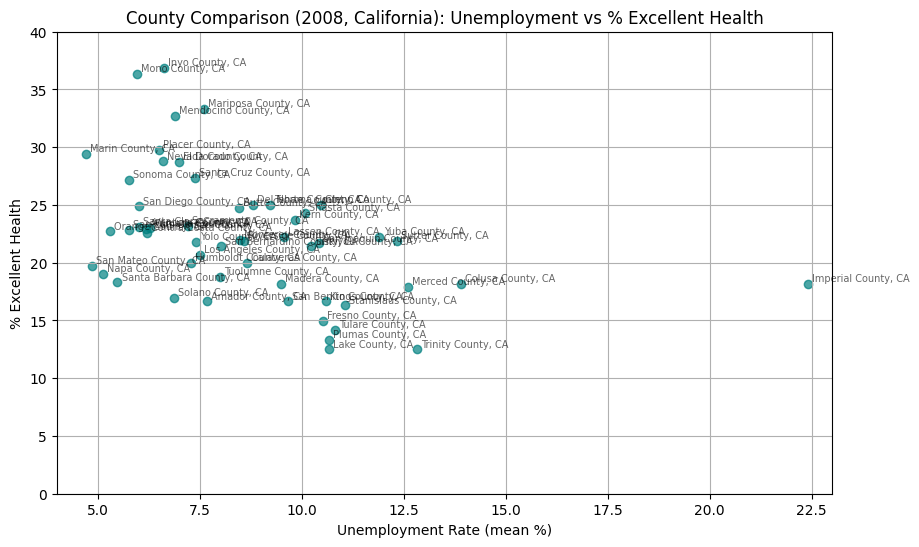

In [3]:
year = 2008  # you can change this to 2005, 2010, etc.
subset = df[df["survey_year"] == year]

plt.figure(figsize=(10,6))
plt.scatter(
    subset["unemployment_rate_mean"], 
    subset["general_health_status - Excellent"], 
    alpha=0.7, color="teal"
)

# Label counties
for i, row in subset.iterrows():
    plt.text(
        row["unemployment_rate_mean"]+0.1, 
        row["general_health_status - Excellent"]+0.2, 
        row["county_name"], fontsize=7, alpha=0.6
    )

plt.title(f"County Comparison ({year}, California): Unemployment vs % Excellent Health")
plt.xlim(4, 23)
plt.ylim(0,40)
plt.xlabel("Unemployment Rate (mean %)")
plt.ylabel("% Excellent Health")
plt.grid(True)
plt.show()

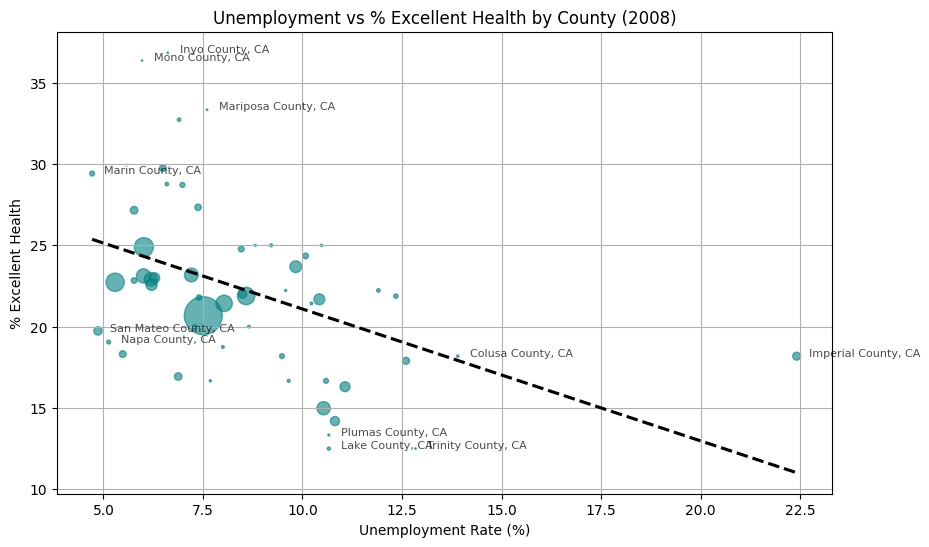

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

year = 2008
subset = df[df["survey_year"] == year].copy()

# If population data exists, use it. Otherwise, fake with labor force size as proxy
subset["pop_weight"] = subset["labor_force_mean"]  # proxy for population

plt.figure(figsize=(10,6))

# Scatter with population-scaled bubbles
sns.regplot(
    x="unemployment_rate_mean", 
    y="general_health_status - Excellent", 
    data=subset, scatter=False, color="black", ci=None, line_kws={"linestyle":"--"}
)

plt.scatter(
    subset["unemployment_rate_mean"], 
    subset["general_health_status - Excellent"], 
    s=subset["pop_weight"]/500,  # scale size
    alpha=0.6, color="teal"
)

# Label only extreme counties (top/bottom 3 unemployment and health)
top_unemp = subset.nlargest(3, "unemployment_rate_mean")
low_unemp = subset.nsmallest(3, "unemployment_rate_mean")
top_health = subset.nlargest(3, "general_health_status - Excellent")
low_health = subset.nsmallest(3, "general_health_status - Excellent")

highlight = pd.concat([top_unemp, low_unemp, top_health, low_health]).drop_duplicates()

for i, row in highlight.iterrows():
    plt.text(row["unemployment_rate_mean"]+0.3,
             row["general_health_status - Excellent"],
             row["county_name"], fontsize=8, alpha=0.7)

plt.title(f"Unemployment vs % Excellent Health by County ({year})")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("% Excellent Health")
plt.grid(True)
plt.show()

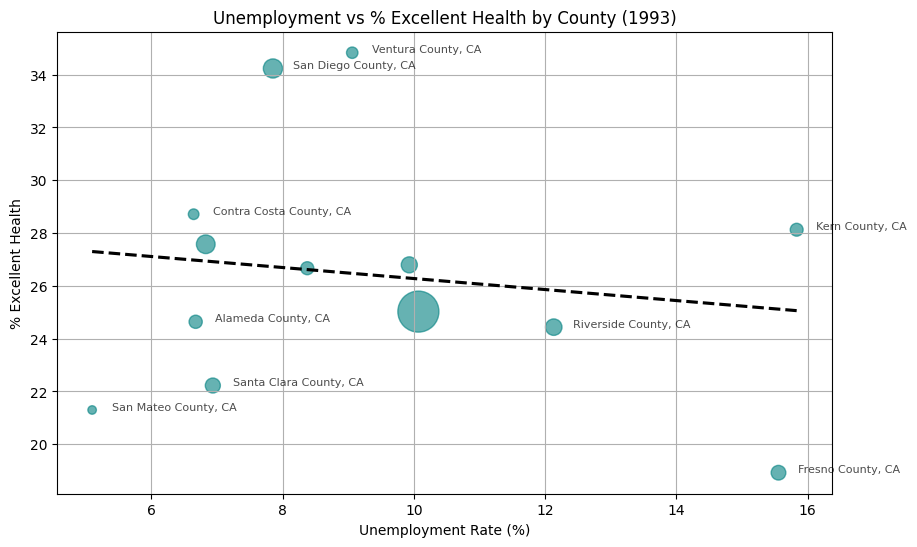

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

years = sorted(df["survey_year"].unique())

fig, ax = plt.subplots(figsize=(10,6))

def update(year):
    ax.clear()
    subset = df[df["survey_year"] == year].copy()
    subset["pop_weight"] = subset["labor_force_mean"]

    # Regression line
    sns.regplot(
        x="unemployment_rate_mean", 
        y="general_health_status - Excellent", 
        data=subset, scatter=False, color="black", ci=None, 
        line_kws={"linestyle":"--"}, ax=ax
    )

    # Bubbles
    ax.scatter(
        subset["unemployment_rate_mean"], 
        subset["general_health_status - Excellent"], 
        s=subset["pop_weight"]/500, alpha=0.6, color="teal"
    )

    # Label extreme counties
    top_unemp = subset.nlargest(3, "unemployment_rate_mean")
    low_unemp = subset.nsmallest(3, "unemployment_rate_mean")
    top_health = subset.nlargest(3, "general_health_status - Excellent")
    low_health = subset.nsmallest(3, "general_health_status - Excellent")
    highlight = pd.concat([top_unemp, low_unemp, top_health, low_health]).drop_duplicates()

    for _, row in highlight.iterrows():
        ax.text(row["unemployment_rate_mean"]+0.3,
                row["general_health_status - Excellent"],
                row["county_name"], fontsize=8, alpha=0.7)

    ax.set_title(f"Unemployment vs % Excellent Health by County ({year})")
    ax.set_xlabel("Unemployment Rate (%)")
    ax.set_ylabel("% Excellent Health")
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=years, interval=1000, repeat=True)

# Render inline as HTML5 animation
HTML(ani.to_jshtml())

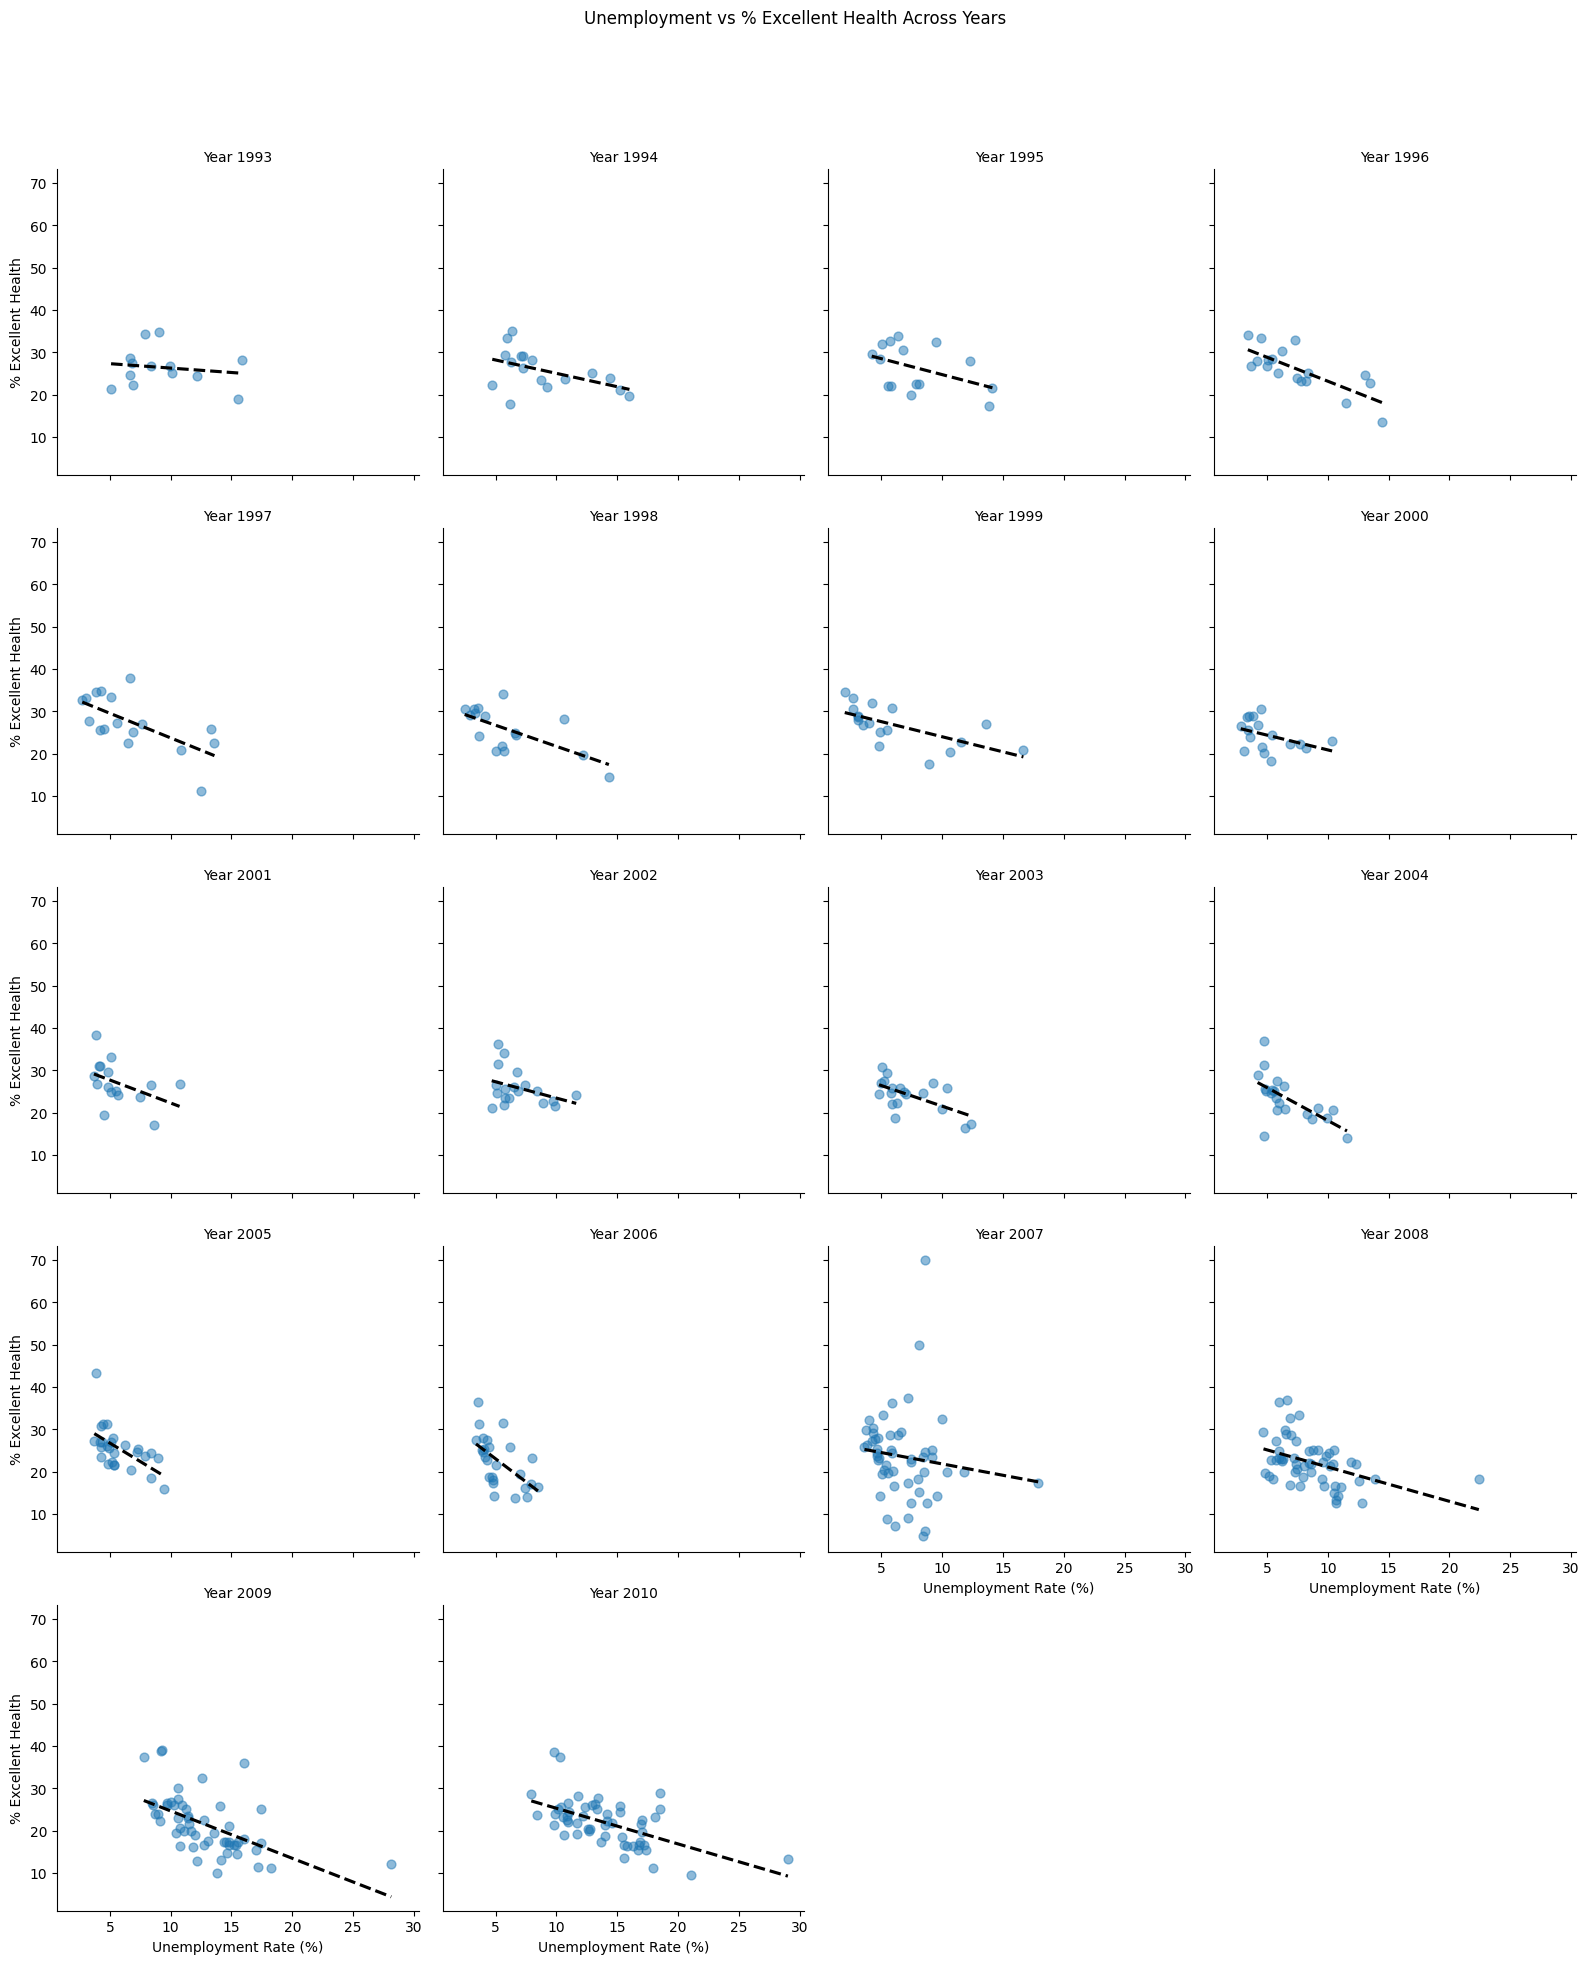

In [6]:
# --- imports
import re, requests, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Config (Michigan by default) ----------
state_cfg = {"name": "California", "fips": "26"}  # change if needed

# ---------- Helper: robust name normalizer ----------
def normalize_name(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower()
    s = s.replace("&", " and ")
    s = re.sub(r",\s*michigan$", "", s)
    s = re.sub(r",\s*mi$", "", s)
    s = re.sub(r"\bcounty\b", "", s)
    s = re.sub(r"\bcity and county of\b", "", s)
    s = re.sub(r"\bst[\.]?\b", "saint", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---------- Helper: find/prepare county name key in your df ----------
def ensure_county_key(df, county_col=None):
    candidates = [county_col, "county", "county_name", "county_name_full", "location", "NAME", "county_fips_name"]
    county_col = next((c for c in candidates if c and c in df.columns), None)
    if not county_col:
        raise ValueError("Add your county column to `candidates` or pass county_col=...")
    dfx = df.copy()
    dfx["county_key"] = dfx[county_col].apply(normalize_name)
    return dfx

# ---------- Pull SAIPE county income for 1993–2010 ----------
# SAIPE variable: SAEMHI_PT = Median household income (dollars), point estimate
# Endpoint: /data/timeseries/poverty/saipe
def fetch_saipe_income_for_year(year: int, state_fips: str) -> pd.DataFrame:
    url = "https://api.census.gov/data/timeseries/poverty/saipe"
    params = {
        "get": "NAME,SAEMHI_PT",
        "time": str(year),
        "for": "county:*",
        "in": f"state:{state_fips}",
    }
    r = requests.get(url, params=params, timeout=60)
    if r.status_code == 204:  # no data for that year (e.g., 1994)
        return pd.DataFrame(columns=["survey_year","state","county","county_name_full","county_key","median_income"])
    r.raise_for_status()
    data = r.json()
    cols, rows = data[0], data[1:]
    df = pd.DataFrame(rows, columns=cols)
    df.rename(columns={"SAEMHI_PT": "median_income"}, inplace=True)
    df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")
    df["county_name_full"] = df["NAME"]
    df["county_key"] = df["county_name_full"].apply(normalize_name)
    df["survey_year"] = year
    return df[["survey_year","state","county","county_name_full","county_key","median_income"]]

def fetch_saipe_income_range(start_year: int, end_year: int, state_fips: str) -> pd.DataFrame:
    frames = []
    for y in range(start_year, end_year + 1):
        try:
            frames.append(fetch_saipe_income_for_year(y, state_fips))
        except requests.HTTPError as e:
            print(f"[warn] {y}: {e}")
        except Exception as e:
            print(f"[warn] {y}: {e}")
    if not frames:
        return pd.DataFrame(columns=["survey_year","state","county","county_name_full","county_key","median_income"])
    out = pd.concat(frames, ignore_index=True)
    # drop empty years cleanly
    out = out[out["median_income"].notna()].reset_index(drop=True)
    return out

# ---------- JOIN income -> your df & create above/below flags ----------
def attach_income_and_flag(df, state_fips: str, start_year=1993, end_year=2010, county_col=None):
    dfx = ensure_county_key(df, county_col=county_col).copy()
    saipe = fetch_saipe_income_range(start_year, end_year, state_fips)
    if saipe.empty:
        raise RuntimeError("No SAIPE income could be fetched for the requested range.")
    merged = dfx.merge(
        saipe[["survey_year","county_key","median_income"]],
        on=["survey_year","county_key"],
        how="left",
        validate="m:1"
    )
    # per-year medians across available counties
    year_meds = merged.groupby("survey_year", dropna=False)["median_income"].median().rename("year_median_income")
    merged = merged.merge(year_meds, on="survey_year", how="left")
    merged["income_position"] = pd.NA
    mask_valid = merged["median_income"].notna() & merged["year_median_income"].notna()
    merged.loc[mask_valid & (merged["median_income"] < merged["year_median_income"]), "income_position"] = "below"
    merged.loc[mask_valid & (merged["median_income"] >= merged["year_median_income"]), "income_position"] = "above"
    return merged

# ---------- Plotter (your original styling) ----------
def plot_health_vs_unemp(dfx, title):
    g = sns.lmplot(
        x="unemployment_rate_mean",
        y="general_health_status - Excellent",
        col="survey_year",
        col_wrap=4,
        data=dfx,
        scatter_kws={"s": 40, "alpha": 0.5},
        line_kws={"linestyle": "--", "color": "black"},
        ci=None, height=4
    )
    g.set_axis_labels("Unemployment Rate (%)", "% Excellent Health")
    g.set_titles("Year {col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title)
    plt.show()

# ---------- RUN for 1993–2010 ----------
df_aug = attach_income_and_flag(df, state_fips=state_cfg["fips"], start_year=1993, end_year=2010, county_col=None)

below = df_aug[df_aug["income_position"].eq("below")].copy()
above = df_aug[df_aug["income_position"].eq("above")].copy()

print("Years with SAIPE coverage in this run:",
      sorted(df_aug.loc[df_aug["median_income"].notna(),"survey_year"].unique()))
print("Below-median rows:", len(below), " | Above-median rows:", len(above))

plot_health_vs_unemp(below, "Unemployment vs % Excellent Health — Counties BELOW Yearly Median Income (SAIPE 1993–2010)")
plot_health_vs_unemp(above, "Unemployment vs % Excellent Health — Counties AT/ABOVE Yearly Median Income (SAIPE 1993–2010)")


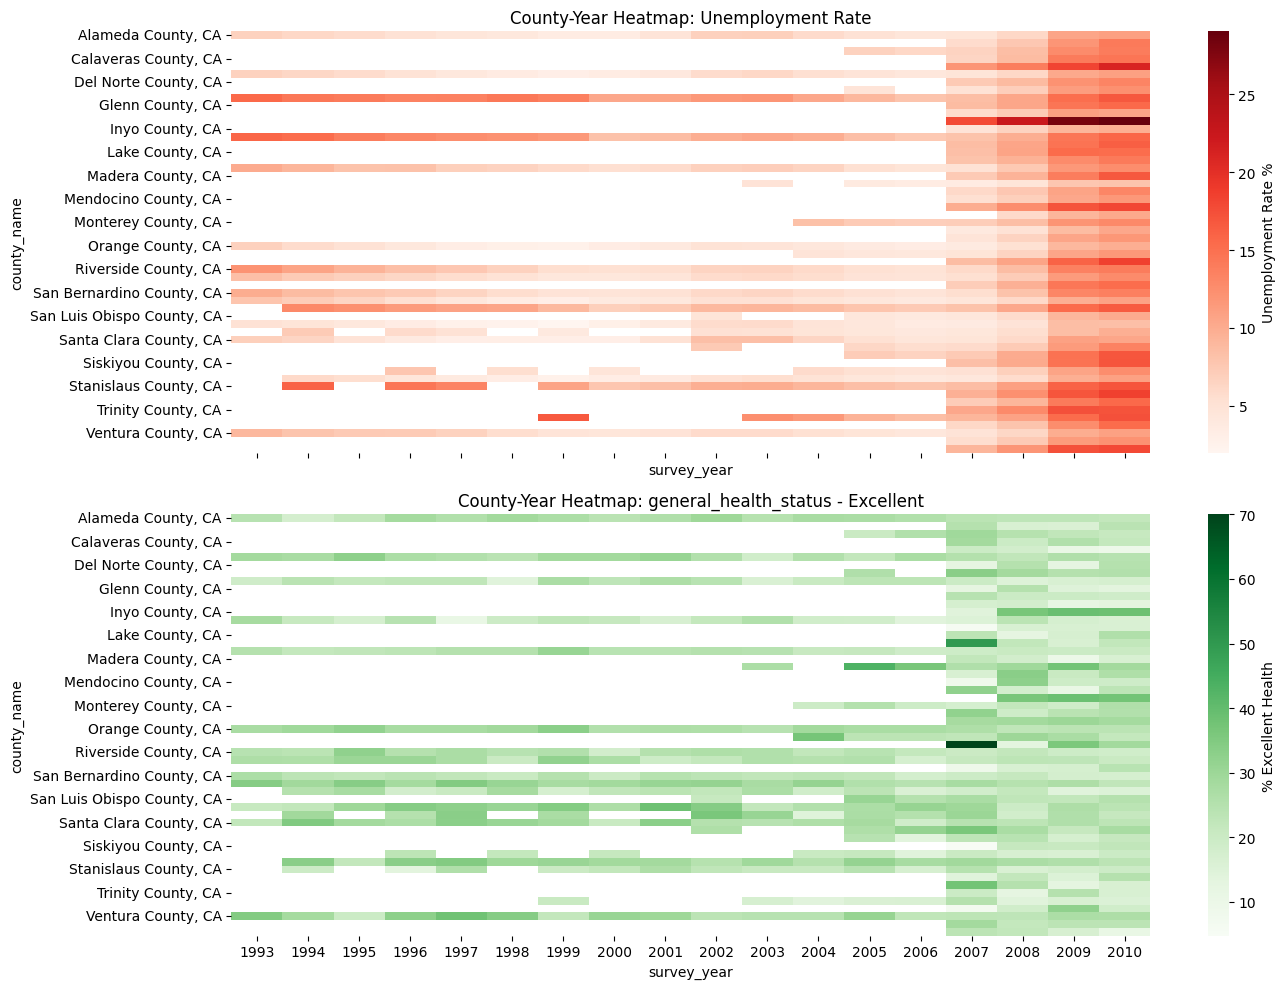

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose outcome to compare with unemployment
health_var = "general_health_status - Excellent"

# Pivot tables: counties × years
unemp_pivot = df.pivot_table(index="county_name", columns="survey_year", values="unemployment_rate_mean")
health_pivot = df.pivot_table(index="county_name", columns="survey_year", values=health_var)

fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Heatmap for unemployment
sns.heatmap(unemp_pivot, cmap="Reds", ax=axes[0], cbar_kws={'label': 'Unemployment Rate %'})
axes[0].set_title("County-Year Heatmap: Unemployment Rate")

# Heatmap for health
sns.heatmap(health_pivot, cmap="Greens", ax=axes[1], cbar_kws={'label': '% Excellent Health'})
axes[1].set_title(f"County-Year Heatmap: {health_var}")

plt.tight_layout()
plt.show()

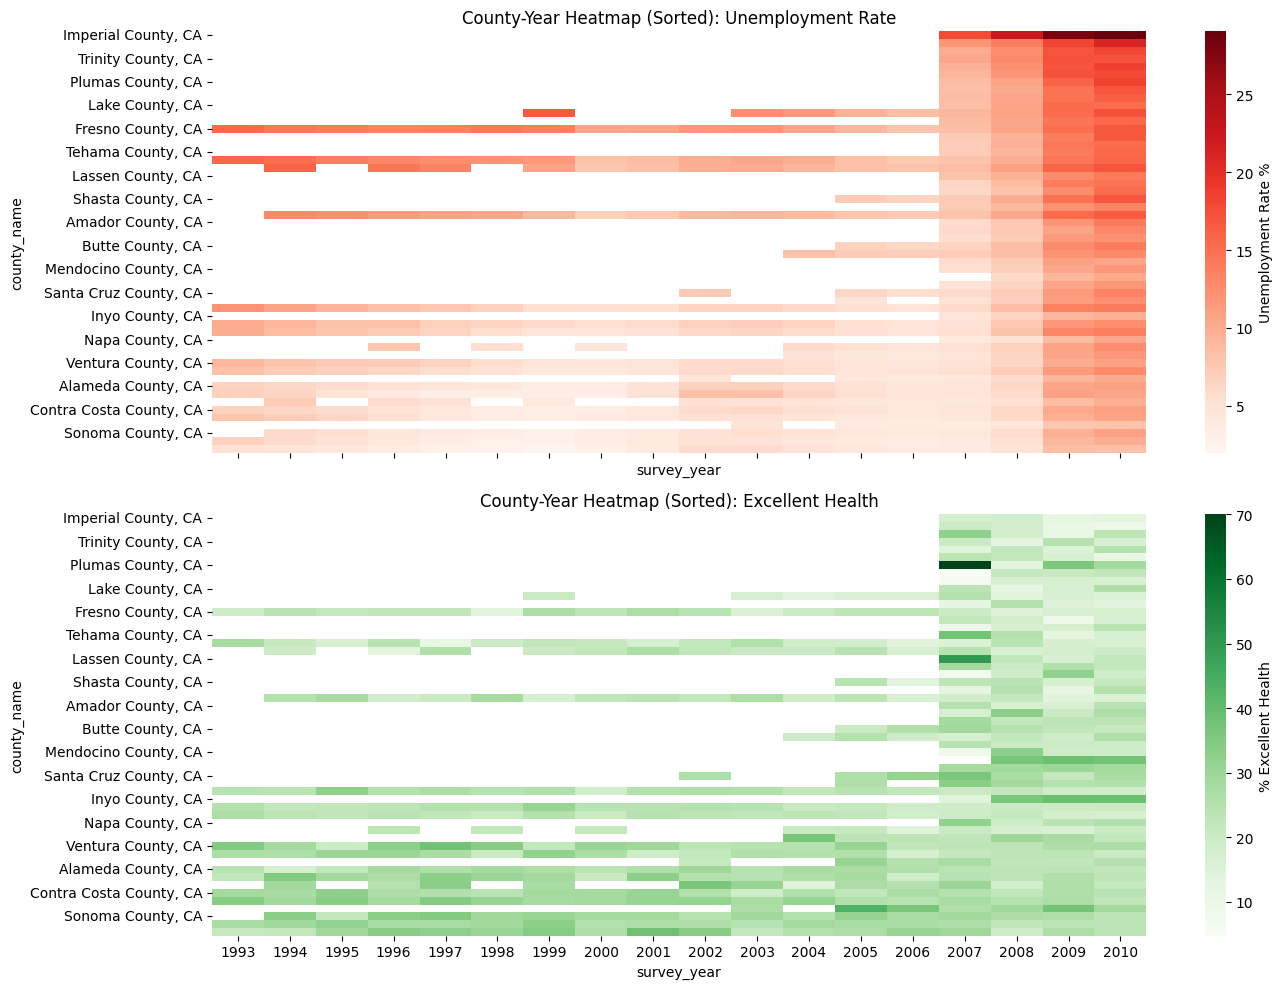

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute average unemployment across years per county
county_order = (
    df.groupby("county_name")["unemployment_rate_mean"]
    .mean()
    .sort_values(ascending=False)  # highest unemployment at top
    .index
)

# Pivot tables for unemployment & health
unemp_pivot = df.pivot_table(
    index="county_name", columns="survey_year", values="unemployment_rate_mean"
).loc[county_order]

health_pivot = df.pivot_table(
    index="county_name", columns="survey_year", values="general_health_status - Excellent"
).loc[county_order]

# Plot side-by-side heatmaps
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.heatmap(unemp_pivot, cmap="Reds", ax=axes[0], cbar_kws={'label': 'Unemployment Rate %'})
axes[0].set_title("County-Year Heatmap (Sorted): Unemployment Rate")

sns.heatmap(health_pivot, cmap="Greens", ax=axes[1], cbar_kws={'label': '% Excellent Health'})
axes[1].set_title("County-Year Heatmap (Sorted): Excellent Health")

plt.tight_layout()
plt.show()

In [9]:
import folium
import pandas as pd
import requests, json
from branca.element import Element

# Pick a year
year = 2010
subset = df[df["survey_year"] == year].copy()

# Clean county names to match GeoJSON property "name"
subset["county_clean"] = subset["county_name"].str.replace(" County, CA", "", regex=False)

# Load California GeoJSON as dict
geo = requests.get(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
).json()

print(geo)

# Choose cutoffs (use medians by default)
u_cut = subset["unemployment_rate_mean"].median()
h_cut = subset["general_health_status - Excellent"].median()

# Create bins
subset["u_bin2"] = (subset["unemployment_rate_mean"] > u_cut).astype(int)
subset["h_bin2"] = (subset["general_health_status - Excellent"] <= h_cut).astype(int)

# Quadrant labels
quad_labels = {
    (0,0): "Low unemployment + High % Excellent Health",
    (0,1): "High unemployment + High % Excellent Health",
    (1,0): "Low unemployment + Low % Excellent Health",
    (1,1): "High unemployment + Low % Excellent Health",
}
subset["quadrant"] = subset.apply(
    lambda r: quad_labels[(int(r["h_bin2"]), int(r["u_bin2"]))], axis=1
)

# Quadrant colors
bivar2_colors = {
    (0,0): "#2ca25f",  # green
    (0,1): "#1f9fb5",  # teal
    (1,0): "#fdae61",  # amber
    (1,1): "#d73027",  # red
}
subset["bivar2_color"] = subset.apply(
    lambda r: bivar2_colors[(int(r["h_bin2"]), int(r["u_bin2"]))], axis=1
)

# Build lookup dict
lookup = subset.set_index("county_clean")[
    ["bivar2_color", "quadrant", "unemployment_rate_mean", "general_health_status - Excellent"]
].rename(columns={
    "bivar2_color": "bivar2",
    "unemployment_rate_mean": "unemp_pct",
    "general_health_status - Excellent": "excellent_pct"
}).to_dict(orient="index")

# Merge into GeoJSON
for feat in geo["features"]:
    name = feat["properties"]["name"]  # CA GeoJSON uses "name"
    rec = lookup.get(name)
    if rec:
        feat["properties"].update({
            "bivar2": rec["bivar2"],
            "quadrant": rec["quadrant"],
            "unemp_pct": round(rec["unemp_pct"], 1),
            "excellent_pct": round(rec["excellent_pct"], 1),
        })
    else:
        feat["properties"].update({
            "bivar2": "#000000",
            "quadrant": "No data",
            "unemp_pct": None,
            "excellent_pct": None,
        })

# Build map
m = folium.Map(location=[37.5, -119.5], zoom_start=6)

folium.GeoJson(
    geo,
    style_function=lambda f: {
        "fillColor": f["properties"]["bivar2"],
        "color": "white",
        "weight": 0.6,
        "fillOpacity": 0.9
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "unemp_pct", "excellent_pct", "quadrant"],
        aliases=["County:", "Unemployment (%):", "% Excellent Health:", "Category:"],
        localize=True,
        sticky=False
    )
).add_to(m)

# Legend
legend_html = f"""
<style>
  .bivar2-card {{
    position: fixed; bottom: 30px; left: 30px;
    background: #fff; border: 3px solid #555; border-radius: 12px;
    padding: 20px; font: 16px/1.4 Arial, sans-serif; color: #222;
    z-index: 9999; box-shadow: 0 4px 8px rgba(0,0,0,.25);
    pointer-events: none; display: inline-block;
  }}
  .title {{ font-weight: 700; margin-bottom: 8px; }}
  .grid {{ display: grid; grid-template-columns: repeat(2, 220px); gap: 6px; }}
  .cell {{ display:flex; align-items:center; gap:8px; padding:6px;
           border:1px solid #ccc; border-radius:4px; }}
  .swatch {{ width:18px; height:18px; border:1px solid #666; }}
  .note {{ margin-top:8px; font-size:11px; color:#444; }}
</style>

<div class="bivar2-card">
  <div class="title">Bivariate Legend</div>
  <div class="grid">
    <div class="cell"><div class="swatch" style="background:#2ca25f"></div>
      Low unemployment + High % Excellent Health
    </div>
    <div class="cell"><div class="swatch" style="background:#1f9fb5"></div>
      High unemployment + High % Excellent Health
    </div>
    <div class="cell"><div class="swatch" style="background:#fdae61"></div>
      Low unemployment + Low % Excellent Health
    </div>
    <div class="cell"><div class="swatch" style="background:#d73027"></div>
      High unemployment + Low % Excellent Health
    </div>
  </div>
  <div class="note">
    Cutoffs — Unemployment: <b>{u_cut:.1f}%</b> (median);
    % Excellent Health: <b>{h_cut:.1f}%</b> (median).<br>
    Colors categorize counties by being above/below these cutoffs;
    black = missing/no match.
  </div>
</div>
"""
m.get_root().html.add_child(Element(legend_html))

m


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'name': 'Alameda', 'cartodb_id': 1, 'created_at': '2015-07-04T21:04:58Z', 'updated_at': '2015-07-04T21:04:58Z'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.312934, 37.897333], [-122.28848, 37.897925], [-122.27418, 37.905025], [-122.263946, 37.903734], [-122.249477, 37.893086], [-122.248914, 37.886867], [-122.223878, 37.878326], [-122.216276, 37.868822], [-122.220389, 37.864427], [-122.204094, 37.851387], [-122.196101, 37.842005], [-122.184177, 37.833926], [-122.185977, 37.820726], [-122.166873, 37.813424], [-122.157392, 37.817952], [-122.148808, 37.81376], [-122.140551, 37.804594], [-122.045473, 37.798126], [-122.030472, 37.787727], [-122.014072, 37.780227], [-121.997771, 37.763227], [-122.010771, 37.755127], [-122.011771, 37.747428], [-121.989971, 37.733628], [-121.97247, 37.728528], [-121.96077, 37.718629], [-121.910138, 37.73046], [-121.780364, 37.761827], [-121.666262, 37.790427], [-121.

In [10]:
import time
import requests
import pandas as pd
import re
import statsmodels.api as sm

STATE = "CA"
STATE_FIPS = {"MI": "26", "CA": "06"}[STATE]
YEARS = range(1993, 2011)  # we'll gracefully skip years without county data

def normalize_name(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower().replace("&", " and ")
    if STATE == "MI":
        s = re.sub(r",\s*michigan$", "", s); s = re.sub(r",\s*mi$", "", s)
    else:
        s = re.sub(r",\s*california$", "", s); s = re.sub(r",\s*ca$", "", s)
    s = re.sub(r"\bcounty\b", "", s)
    s = re.sub(r"\bst[.]?\b", "saint", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def _census_get_json(url, params, max_retries=3, timeout=20):
    headers = {"User-Agent": "research/analytics (contact: your-email@example.com)"}
    for attempt in range(1, max_retries+1):
        r = requests.get(url, params=params, headers=headers, timeout=timeout)
        # Retry on rate limits / transient errors
        if r.status_code in (429, 500, 502, 503, 504):
            time.sleep(1.5 * attempt)
            continue
        # Try JSON if content-type looks right
        ctype = r.headers.get("Content-Type", "")
        text = r.text.strip() if r.text else ""
        if "json" in ctype.lower():
            try:
                return r.json()
            except requests.JSONDecodeError:
                pass  # fall through to informative error below

        # If we get here, it wasn't valid JSON; show a short clue
        snippet = text[:300].replace("\n", " ")
        raise RuntimeError(
            f"Census API non-JSON response (HTTP {r.status_code}). "
            f"content-type={ctype}. Snippet: {snippet}"
        )
    raise RuntimeError(f"Census API retries exceeded for {url} with params={params}")

def fetch_income_saipe(year: int, state_fips: str) -> pd.DataFrame:
    """
    SAIPE county-level median household income (SAEMHI_PT).
    Some early years (e.g., 1993–1994) have no county data; we detect and raise a clean message.
    """
    base = "https://api.census.gov/data/timeseries/poverty/saipe"
    params = {
        "get": "NAME,SAEMHI_PT",
        "for": "county:*",
        "in": f"state:{state_fips}",
        "time": str(year),
    }
    data = _census_get_json(base, params=params)
    cols, rows = data[0], data[1:]
    if not rows:
        # No county data for this year/state
        raise ValueError(f"No SAIPE county data for year {year} (state {state_fips}).")
    df = pd.DataFrame(rows, columns=cols)
    # If SAIPE returns the "There are no data for the time period" page, we'd have errored earlier.
    df["SAEMHI_PT"] = pd.to_numeric(df["SAEMHI_PT"], errors="coerce")
    df["county_key"] = df["NAME"].apply(normalize_name)
    return df.rename(columns={"SAEMHI_PT": "median_income"})[["county_key", "median_income"]]

def fetch_income(year: int, state_fips: str) -> pd.DataFrame:
    # Keep it simple: SAIPE for all years; we’ll just skip years with no county coverage.
    return fetch_income_saipe(year, state_fips)

# Your provided df is assumed to exist with required columns
REQUIRED_COLS = {
    "county_name",
    "unemployment_rate_mean",
    "general_health_status - Excellent",
    "survey_year",
}
def get_subset(year: int) -> pd.DataFrame:
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise KeyError(f"df is missing required columns: {sorted(missing)}")
    sub = df.loc[df["survey_year"] == year, [
        "county_name",
        "unemployment_rate_mean",
        "general_health_status - Excellent",
    ]].copy()
    # aggregate (no-op if already one row per county)
    sub = (
        sub.groupby("county_name", as_index=False)
           .agg({
               "unemployment_rate_mean": "mean",
               "general_health_status - Excellent": "mean",
           })
           .dropna(subset=["unemployment_rate_mean", "general_health_status - Excellent"])
    )
    return sub

def run_yearly_regressions(
    years=YEARS,
    state_fips=STATE_FIPS,
    robust_cov="HC3",
):
    results, models = [], {}
    for yr in years:
        try:
            income_df = fetch_income(yr, state_fips)
        except ValueError as e:
            # Probably a year with no county data (e.g., 1993–1994) — skip cleanly.
            print(f"[{yr}] {e} Skipping.")
            results.append({"year": yr, "n": 0, "const": None, "beta_unemp": None,
                            "beta_income": None, "se_unemp": None, "se_income": None, "r2": None})
            continue
        except RuntimeError as e:
            # Network/format issue — record and continue
            print(f"[{yr}] Census error: {e} Skipping.")
            results.append({"year": yr, "n": 0, "const": None, "beta_unemp": None,
                            "beta_income": None, "se_unemp": None, "se_income": None, "r2": None})
            continue

        subset_year = get_subset(yr).copy()
        if subset_year.empty:
            print(f"[{yr}] subset is empty; skipping.")
            results.append({"year": yr, "n": 0, "const": None, "beta_unemp": None,
                            "beta_income": None, "se_unemp": None, "se_income": None, "r2": None})
            continue

        subset_year["county_key"] = subset_year["county_name"].apply(normalize_name)
        merged = (
            subset_year[["county_key", "unemployment_rate_mean", "general_health_status - Excellent"]]
            .merge(income_df[["county_key", "median_income"]], on="county_key", how="inner")
            .dropna(subset=["median_income", "unemployment_rate_mean", "general_health_status - Excellent"])
        )

        print(f"[{yr}] rows merged: {len(merged)}")
        if len(merged) == 0:
            results.append({"year": yr, "n": 0, "const": None, "beta_unemp": None,
                            "beta_income": None, "se_unemp": None, "se_income": None, "r2": None})
            continue

        X = sm.add_constant(merged[["unemployment_rate_mean", "median_income"]])
        y = merged["general_health_status - Excellent"]
        model = sm.OLS(y, X).fit(cov_type=robust_cov)

        params, bse = model.params, model.bse
        results.append({
            "year": yr,
            "n": int(model.nobs),
            "const": params.get("const"),
            "beta_unemp": params.get("unemployment_rate_mean"),
            "beta_income": params.get("median_income"),
            "se_unemp": bse.get("unemployment_rate_mean"),
            "se_income": bse.get("median_income"),
            "r2": model.rsquared,
        })
        models[yr] = model

    return pd.DataFrame(results).sort_values("year"), models


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ols_evolution(results_df: pd.DataFrame, title_prefix: str = ""):
    """
    Expects columns:
      year, beta_unemp, beta_income, se_unemp, se_income, r2, n
    Produces four separate figures (no specific colors/styles set).
    """
    df = results_df.dropna(subset=["year"]).sort_values("year").copy()
    # Compute 95% CI bands
    for coef, se in [("beta_unemp", "se_unemp"), ("beta_income", "se_income")]:
        if coef in df and se in df:
            df[f"{coef}_lo"] = df[coef] - 1.96 * df[se]
            df[f"{coef}_hi"] = df[coef] + 1.96 * df[se]

    # Helper to prettify titles
    def t(s): 
        return f"{title_prefix} – {s}" if title_prefix else s

    # 1) β_unemployment with 95% CI
    if {"beta_unemp", "beta_unemp_lo", "beta_unemp_hi"}.issubset(df.columns):
        plt.figure()
        plt.plot(df["year"], df["beta_unemp"], marker="o")
        plt.fill_between(df["year"], df["beta_unemp_lo"], df["beta_unemp_hi"], alpha=0.2)
        plt.axhline(0, linestyle="--", linewidth=1)
        plt.xlabel("Year")
        plt.ylabel("Coefficient on unemployment")
        plt.title(t("β (unemployment) with 95% CI"))
        plt.tight_layout()

    # 2) β_income with 95% CI
    if {"beta_income", "beta_income_lo", "beta_income_hi"}.issubset(df.columns):
        plt.figure()
        plt.plot(df["year"], df["beta_income"], marker="o")
        plt.fill_between(df["year"], df["beta_income_lo"], df["beta_income_hi"], alpha=0.2)
        plt.axhline(0, linestyle="--", linewidth=1)
        plt.xlabel("Year")
        plt.ylabel("Coefficient on income (median household)")
        plt.title(t("β (income) with 95% CI"))
        plt.tight_layout()

    # 3) R^2 over time
    if "r2" in df:
        plt.figure()
        plt.plot(df["year"], df["r2"], marker="o")
        plt.ylim(0, 1)
        plt.xlabel("Year")
        plt.ylabel("R²")
        plt.title(t("Model R² over time"))
        plt.tight_layout()

    # 4) Sample size over time
    if "n" in df:
        plt.figure()
        plt.plot(df["year"], df["n"], marker="o")
        plt.xlabel("Year")
        plt.ylabel("N (observations)")
        plt.title(t("Sample size by year"))
        plt.tight_layout()

    # Optional quick stability metrics in the console:
    # Change rate (slope) via simple OLS on year -> coef
    def slope_stat(y):
        y = df[y].dropna()
        if len(y) < 3: 
            return None
        X = np.vstack([np.ones(len(y)), y.index.values]).T  # not ideal if index not aligned
        return None

# Example:


[1993] rows merged: 13
[1994] Census error: Census API non-JSON response (HTTP 204). content-type=application/json;charset=utf-8. Snippet:  Skipping.
[1995] rows merged: 15
[1996] rows merged: 0
[1997] rows merged: 17
[1998] rows merged: 16
[1999] rows merged: 18
[2000] rows merged: 17
[2001] rows merged: 16
[2002] rows merged: 19
[2003] rows merged: 19
[2004] rows merged: 21
[2005] rows merged: 27
[2006] rows merged: 26
[2007] rows merged: 53
[2008] rows merged: 54
[2009] rows merged: 54
[2010] rows merged: 54


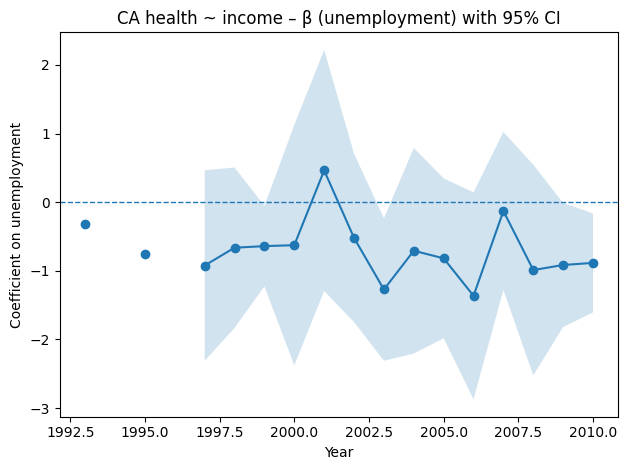

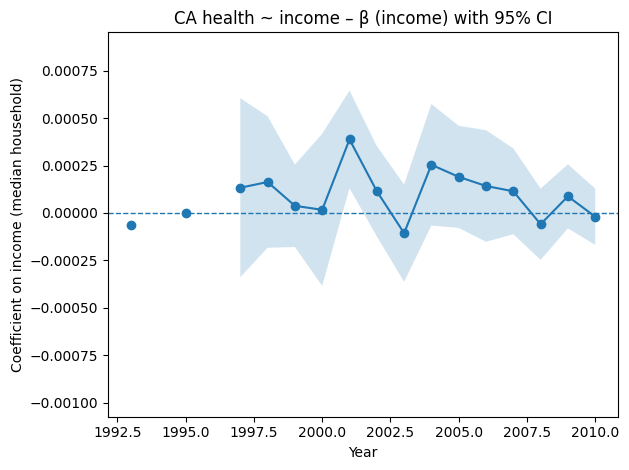

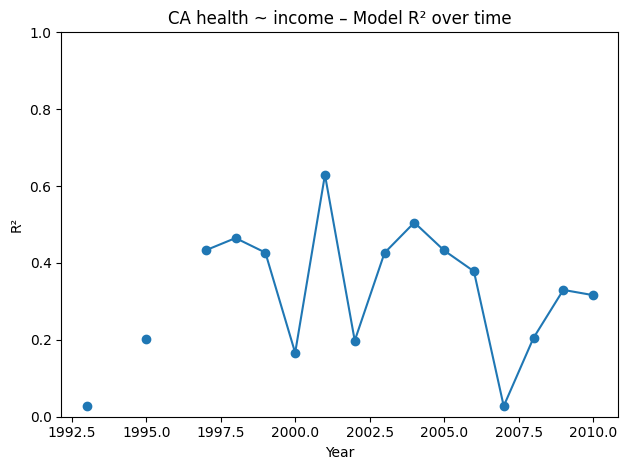

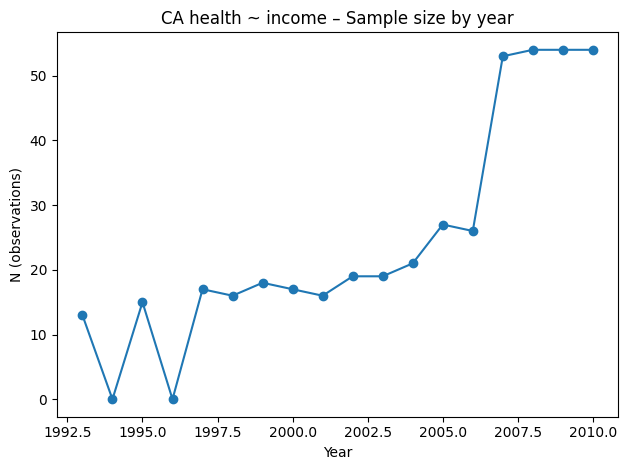

In [12]:

results_df, models = run_yearly_regressions()
plot_ols_evolution(results_df, title_prefix=f"{STATE} health ~ income")
plt.show()

In [13]:
import statsmodels.api as sm
import pandas as pd

def compare_models_across_years(years, state_fips=STATE_FIPS, robust_cov="HC3"):
    records = []
    
    for yr in years:
        try:
            income_df = fetch_income(yr, state_fips)
        except Exception as e:
            print(f"[{yr}] income fetch failed: {e}")
            continue

        subset_year = get_subset(yr)
        if subset_year.empty:
            print(f"[{yr}] subset empty; skipping.")
            continue

        subset_year["county_key"] = subset_year["county_name"].apply(normalize_name)
        merged = (
            subset_year[["county_key", "unemployment_rate_mean", "general_health_status - Excellent"]]
            .merge(income_df[["county_key", "median_income"]], on="county_key", how="inner")
            .dropna(subset=["median_income", "unemployment_rate_mean", "general_health_status - Excellent"])
        )
        nobs = len(merged)
        if nobs == 0:
            print(f"[{yr}] no merged data.")
            continue

        y = merged["general_health_status - Excellent"]

        # Spec 1: Health ~ Income
        X1 = sm.add_constant(merged[["median_income"]])
        m1 = sm.OLS(y, X1).fit(cov_type=robust_cov)

        # Spec 2: Health ~ Unemployment
        X2 = sm.add_constant(merged[["unemployment_rate_mean"]])
        m2 = sm.OLS(y, X2).fit(cov_type=robust_cov)

        # Spec 3: Health ~ Income + Unemployment
        X3 = sm.add_constant(merged[["median_income", "unemployment_rate_mean"]])
        m3 = sm.OLS(y, X3).fit(cov_type=robust_cov)

        records.append({
            "year": yr,
            "n": nobs,

            # --- Spec 1
            "r2_income": m1.rsquared,
            "adjr2_income": m1.rsquared_adj,
            "aic_income": m1.aic,
            "bic_income": m1.bic,
            "coef_income_only": m1.params.get("median_income", float("nan")),

            # --- Spec 2
            "r2_unemp": m2.rsquared,
            "adjr2_unemp": m2.rsquared_adj,
            "aic_unemp": m2.aic,
            "bic_unemp": m2.bic,
            "coef_unemp_only": m2.params.get("unemployment_rate_mean", float("nan")),

            # --- Spec 3
            "r2_both": m3.rsquared,
            "adjr2_both": m3.rsquared_adj,
            "aic_both": m3.aic,
            "bic_both": m3.bic,
            "coef_income_joint": m3.params.get("median_income", float("nan")),
            "coef_unemp_joint": m3.params.get("unemployment_rate_mean", float("nan")),
        })
    
    results_df = pd.DataFrame(records).sort_values("year")
    return results_df


[1996] no merged data.
   year   n  r2_income  adjr2_income  aic_income  bic_income  \
0  1995  15   0.123341      0.055906   94.142403   95.558504   
1  1997  17   0.320813      0.275533  108.479733  110.146159   
2  1998  16   0.384457      0.340490   94.037900   95.583077   
3  1999  18   0.278827      0.233753  103.885678  105.666421   
4  2000  17   0.115215      0.056229   92.712793   94.379219   

   coef_income_only  r2_unemp  adjr2_unemp   aic_unemp   bic_unemp  \
0          0.000239  0.202144     0.140771   92.729559   94.145659   
1          0.000425  0.419664     0.380975  105.805804  107.472230   
2          0.000351  0.429694     0.388958   92.816586   94.361763   
3          0.000224  0.423513     0.387483   99.854981  101.635725   
4          0.000105  0.165250     0.109600   91.723171   93.389598   

   coef_unemp_only   r2_both  adjr2_both    aic_both    bic_both  \
0        -0.753761  0.202144    0.069168   94.729558   96.853709   
1        -1.164733  0.433038    0.3

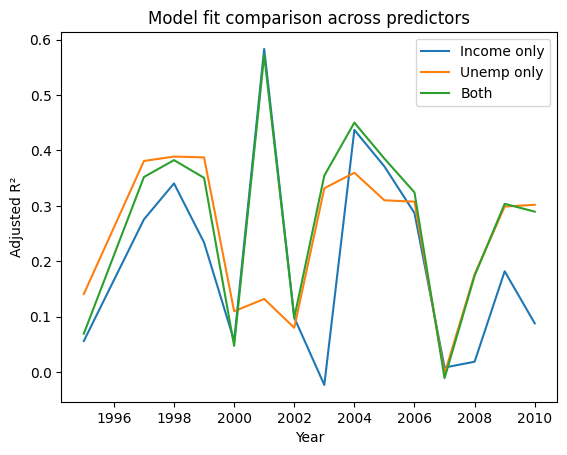

In [14]:
years = range(1995, 2011)  # safer than starting at 1993
results_cmp = compare_models_across_years(years)

# Look at first few rows
print(results_cmp.head())

# Example: plot adjusted R² for each spec
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_cmp["year"], results_cmp["adjr2_income"], label="Income only")
plt.plot(results_cmp["year"], results_cmp["adjr2_unemp"], label="Unemp only")
plt.plot(results_cmp["year"], results_cmp["adjr2_both"], label="Both")
plt.ylabel("Adjusted R²")
plt.xlabel("Year")
plt.title("Model fit comparison across predictors")
plt.legend()
plt.show()
